# Design frequency-range for Fourier transform in CSEM modelling

Controlled-source electromagnetic responses in three dimenision are usually modelled directly in the domain where you want to process the data, hence a time-domain code for time-domain processing, and a frequency-domain for frequency-domain processing. However, under certain conditions it can be favourable to calculate the model in the
other domain and transform it with a (inverse) Fourier transform. The Fourier transform is generally very fast, in comparison with the 3D calculation of the electromagnetic response.

[Mulder et al., 2008](#References), presented an adaptive frequency selection scheme which showed that if you carefully select the frequencies you only need a a few dozens, and the total runtime can therefore become competitive to time-domain codes. Their scheme can be improved with a few simple steps, and we were able to achieve the same result with 2/3 of their frequencies. However, this adaptive system of Mulder or our improved version has a serious drawback, as the frequency range is very offset dependent. If you move to larger (or smaller) offsets the adaptive scheme will selecte lower (or higher) frequencies. We developed therefore a system to select frequencies with a regular spacing (on a log10-scale), but within a certain range. Using digital linear filters (DLF) and a fast, layered modeller (empymod) to check, we developed an interactive tool to select the best frequency range which covers a wide range of offsets. With just four frequencies per decade over the range of 0.001 Hz to 10 Hz you need only 16 frequencies to cover an offset range from 1 to 10 km with an error-level in the time domain below 1%.

#### References

> Mulder, W. A., M. Wirianto, and E. Slob, 2008, Time-domain modeling of electromagnetic diffusion with a frequency-domain code: Geophysics, 73, F1-F8; DOI: [10.1190/1.2799093](https://doi.org/10.1190/1.2799093).

In [1]:
import emg3d  # only to write-out data, can be commented-out
import empymod
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt

import freqdesign  # Script in this directory

In [2]:
# Style adjustments
%matplotlib notebook
plt.style.use('ggplot')

Uncomment and run the following to have the notebook in full width.

In [3]:
# %%html
# <style>
# .output_wrapper .ui-dialog-titlebar {display: none;}
# .container { width:100% !important; }
# </style>

## Comparison with scheme from Mulder et al., 2008, Geophysics.

**Mulder et al, 2008, Geophysics:**
- Adaptive scheme using PCHIP interpolation and absolute value of the frequency response.
- When a point does not fit the error-criteria, two points are added, one to the left and one to the right.
- The error check is done for all existing frequencies at once.

**This scheme can be improved for two reasons:**
- Only add one point at a time, and check again, because the error of many will improve with just one point added.
- Use the imaginary part, where we know it starts and ends at zero amplitude. Also, add zero amplitude points at f=1e-100 and 1e100 Hz, which improves the interpolation.

**The implemented scheme goes as follows:**
- Check the error of all existing points. Always adjust the lowest frequency which doesn't fit the criteria.
- If the lowest frequency is wrong, add a new point half a decade to the left.
- After that, move to the right, always adding one point halfway between the lowest failing frequency and the following one.
- If the highest frequency is the last remaining, and it fails, add a point half a decade to the right.

### With this scheme, we achiev a result as good or better as Mulder's with only 15 instead of 24 frequencies.

   time        [s] :  0.01 - 100 : 101  [min-max; #]
   Fourier         :  DLF (Sine-Filter)
     > Filter      :  Key 201 CosSin (2012)
     > DLF type    :  Lagged Convolution
   frequency  [Hz] :  1.4626E-09 - 1.9191E+07 : 268  [min-max; #]


<IPython.core.display.Javascript object>


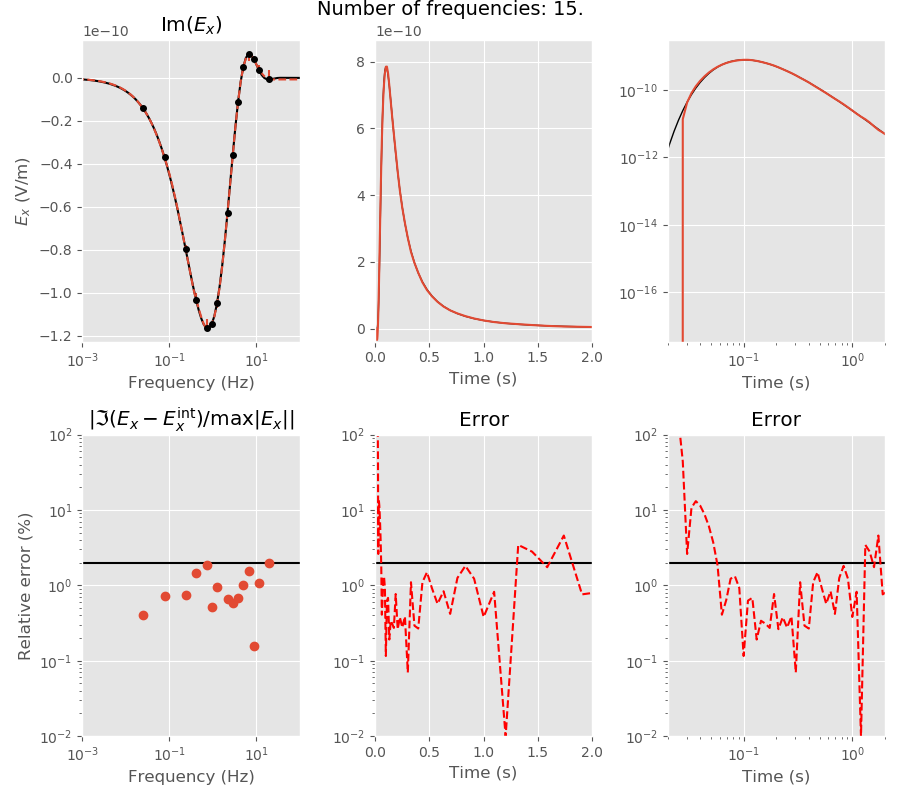

In [4]:
tEM, freq, fEMp = freqdesign.design_freq_range(
    time=np.logspace(-2, 2, 101),
    model={'src': [0, 0, 0], 'rec': [900, 0, 0], 'depth': [], 'res': 1, 'verb': 1},
    rtol=0.02, signal=0, freq_range=3, xlim_freq=[1e-3, 1e2], xlim_lin=[0, 2], xlim_log=[2e-2, 2],
    pause=0.001)

## Multi-offset

The scheme of Mulder has one problem: This interactive frequency determination is very offset dependent, as the frequency range changes a lot with offset. Shorter offset require higher frequencies, longer offsets require lower frequencies.

   time        [s] :  0.1 - 1000 : 101  [min-max; #]
   Fourier         :  DLF (Sine-Filter)
     > Filter      :  Key 201 CosSin (2012)
     > DLF type    :  Lagged Convolution
   frequency  [Hz] :  1.4626E-10 - 1.9191E+06 : 268  [min-max; #]


<IPython.core.display.Javascript object>


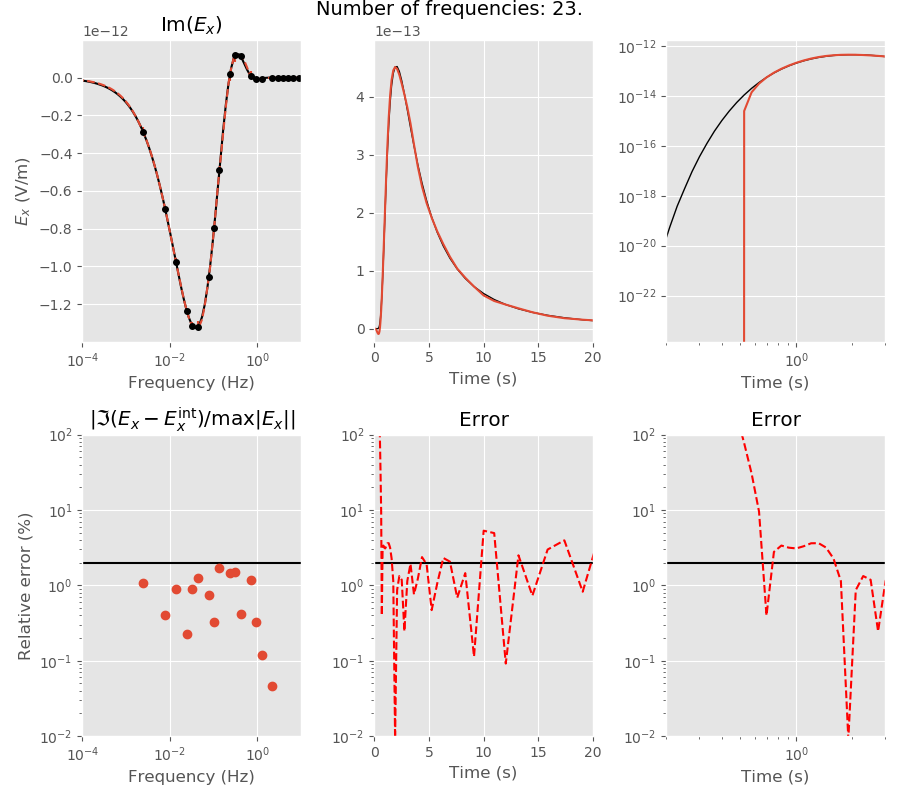

In [5]:
tEM2, freq2, fEMp2 = freqdesign.design_freq_range(
    time=np.logspace(-1, 3, 101),
    model={'src': [0, 0, 0], 'rec': [4000, 0, 0], 'depth': [], 'res': 1, 'verb': 1},
    rtol=0.02, signal=0, freq_range=freq, xlim_freq=[1e-4, 1e1], xlim_lin=[0, 20], xlim_log=[2e-1, 3],
    pause=0.001)

## Interactive frequency selection: standard spline with restricted frequency range.

In 3D modelling, we can always extract a wide range of offset from our result. To be able to transform a wide frequency range we should therefore have a regular spacing, as used in the standard spline version of the DLF, but only calculate a restricted frequency range.

<IPython.core.display.Javascript object>


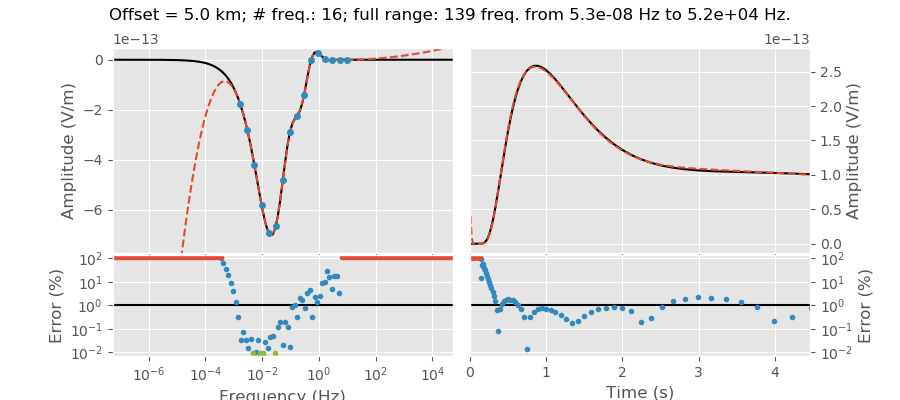

In [6]:
GUI = freqdesign.InteractiveFrequency(
    src_z=950,
    rec_z=1000,
    depth=[0, 1000, 2000, 2100],
    res=[2e14, 0.3, 1, 100, 1],
    time=np.logspace(-2, 3, 201),
    ftarg=['key_81_CosSin_2009', 4]
)

In [7]:
GUI.coarse_freq[GUI.ind]

array([1.68835698e-03, 3.00237045e-03, 5.33905355e-03, 9.49432899e-03,
       1.68835698e-02, 3.00237045e-02, 5.33905355e-02, 9.49432899e-02,
       1.68835698e-01, 3.00237045e-01, 5.33905355e-01, 9.49432899e-01,
       1.68835698e+00, 3.00237045e+00, 5.33905355e+00, 9.49432899e+00])

### Write the data of the current GUI-state

In [8]:
emg3d.utils.data_write(
    'Fullspace-selection',
    ['ind', 'coarse_freq', 'time', 'ft', 'ftfilt', 'pts_per_dec', 'min_freq', 'max_freq', 'req_freq', 'reim'],
    [GUI.ind, GUI.coarse_freq, GUI.time, GUI.ft, GUI.ftfilt, GUI.pts_per_dec, GUI.min_freq, GUI.max_freq, GUI.req_freq, GUI.reim],
    './data',
    0)

   > File exists, NOT SAVING THE DATA.


In [9]:
empymod.Report(emg3d)

--------------------------------------------------------------------------------
  Date: Thu Oct 03 09:56:08 2019 CEST

             Linux : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
           15.5 GB : RAM
           Jupyter : Environment

  Python 3.7.4 (default, Aug 13 2019, 20:35:49)  [GCC 7.3.0]

         0.7.2dev0 : emg3d
            1.16.5 : numpy
             1.3.1 : scipy
         1.8.4dev0 : empymod
             2.7.0 : numexpr
             7.8.0 : IPython
             3.1.1 : matplotlib

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------